# PROJECT WEEK 4
* This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.
* The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.
* Hint: You'll have to undistort the images before rectifying them.
* Hint: Some of the relevant functions you'll be using can be found here.



### So far the best procedure found has been:

#### Undistortion images
1. For all right and left images find the chessboardcorners: objectpoints IRL and imagepoint on imageplane.
2. Use cv2.CalibrateCamera() to get distortion coefficients from the imagepoints
3. Then use cv2.getOptimalNewCameraMatrix(), which is RANSAC + SVD (DLT) to get optimal K matrix.

#### Stereo calibration
1. use cv2.stereoCalibrate() to get R, t, E and F matrix connecting the cameras..
2. Then, use cv2.stereoRectify() to get rotation, translation and projection of each camera.
3. Finally we can use cv2.initUndistortRectifyMap() to create a complete map, which can be used to undistort and rectify all images from the camera. 
        - This is applied using "cv2.remap()"

#### Alternatively

A more intuitive approach, closer to the math, not using stereoCalibrate() can be found from ex4.
Again use cv2.getOptimalNewCameraMatrix() on all corners of the chessboard to estimate the camera matrices K1, K2.

Distortion coefficients for both cameras are again found using the imagepoints and cv2.CalibrateCamera()

THen find F using cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC) where pt1 and pts2 correspond to the 200 best matches found between the two images. Since some of them are outliers its nice to use RANSAC.

E matrix is then found using the definition of E and F: E = K_left.T@F@K_right. 

The rotations and translation is given by cv2.decomposeEssentialMat(E): NB! its just two possible rotations being returned, not left and right!

Then instead of using cv2.stereoRectify() we use the definition of the projection matrices to get them:
P_left = np.hstack((K_left@R_left, K_left@t))
P_right = np.hstack((K_right@R_right, K_right@t))


Now we are ready to produce some maps! cv2.initUndistortRectifyMap(K, dist, R, P,(w,h),cv2.CV_32FC1).

In [32]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

# UNDISTORTION
* Find the chessboard corners and undistort the image
* Camera matrix calculated separately for left and right image

In [33]:
rerun_camera_matrix = False

##################### LEFT IMAGES #########################
if rerun_camera_matrix == True:   
    # Implement the number of vertical and horizontal corners
    nb_vertical = 9
    nb_horizontal = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
    objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints_left = [] # 2d points in image plane.

    images = glob.glob('rs/left*.png')
    assert images

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Implement findChessboardCorners here
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints_left.append(corners)

    # get the camera matrix
    ret, mtx_left, dist_left, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_left, gray.shape[::-1], None, None)
    img_left = cv2.imread('rs/left-0000.png') # just to get dimensions
    h,  w = img.shape[:2]
    K_left, roi = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w,h),1,(w,h))
    # save images into folder
    i = 0
    for fname in images:
        # undistort
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx_left, dist_left, None, K_left)

        # crop the image
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]

        # save image
        cv2.imwrite('undistorted/left'+str(i)+'.png',dst)
        i+=1

    ##################### RIGHT IMAGES #########################

    # Implement the number of vertical and horizontal corners
    nb_vertical = 9
    nb_horizontal = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
    objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints_right = [] # 2d points in image plane.

    images = glob.glob('rs/right*.png')
    assert images

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Implement findChessboardCorners here
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints_right.append(corners)

    # get the camera matrix
    ret, mtx_right, dist_right, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_right, gray.shape[::-1], None, None)
    img_right = cv2.imread('rs/right-0000.png') # just to get dimensions
    h,  w = img.shape[:2]
    K_right, roi = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w,h),1,(w,h))

    # save images into folder
    i = 0
    for fname in images:
        # undistort
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx_right, dist_right, None, K_right)

        # crop the image
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]

        # save image
        cv2.imwrite('undistorted/right'+str(i)+'.png',dst)
        i+=1

# RECTIFY THE IMAGES

## STEP 1: Find the keypoints

<Figure size 720x720 with 0 Axes>

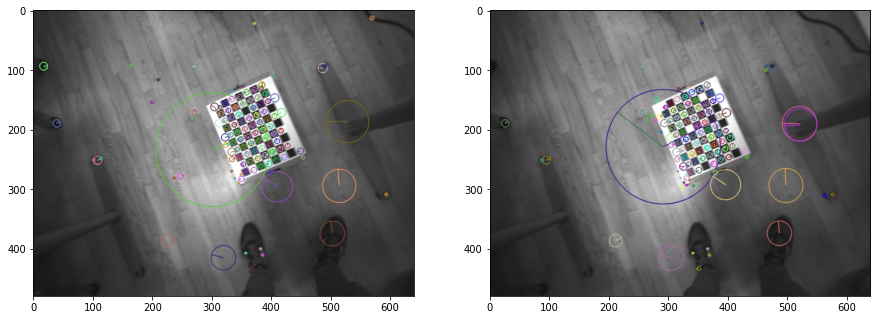

<Figure size 720x720 with 0 Axes>

In [34]:
# Load undistorted images
img_left = cv2.imread('rs/left-0001.png',0)
img_right = cv2.imread('rs/right-0001.png',0)

# Create a sift detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp_left, des_left = sift.detectAndCompute(img_left, None)
kp_right, des_right = sift.detectAndCompute(img_right, None)
kp_img_left = cv2.drawKeypoints(img_left, kp_left, img_left, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_right = cv2.drawKeypoints(img_right, kp_right, img_right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(kp_img_left)
ax2.imshow(kp_img_right)
plt.figure(figsize = (10,10))

## STEP 2: Match the points
- we have 200 points with some outliers
- SVD would explode for 200 points with so many outliers
- RANSAC is choosing 8 random points for SVD (subgroup, we need 4 pairs of points to get the F matrix)
- F matrix maps one points to a line
- Homography works only for planes (like a points on chessboard where we can reduce one dimension)
- transpose F if we want to get the points the other way (img2->img1)
- The essential matrix includes the pose of the cameras with respect to each other
- The fundamental matrix projects a point in the right image frame to a point in the left image.

In [35]:
matches = cv2.BFMatcher().match(des_left, des_right)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 200

good = []
pts1 = []
pts2 = []

# Using 200 best matches
for m in matches[:nb_matches]:
    good.append(m)
    # Extract points corresponding to matches.
    pts1.append(kp_left[m.queryIdx].pt)
    pts2.append(kp_right[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2) 

## STEP 3: Get the fundamental matrix
* As stated before, we use RAMSAC combined with SVD to find the fundamental matrix
* Simply we just pair 8 points until we find the best fit

In [36]:
# get fundamental matrix
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)
print(F)

# remove outliers
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

[[-2.85832348e-20 -3.08641975e-04  5.00000000e-02]
 [ 3.08641975e-04  3.21948516e-20 -1.18233545e-01]
 [-5.00000000e-02  1.12060706e-01  1.00000000e+00]]


## STEP 4: Draw the epipolar lines
- if we pass the image into function, it somehow rewrites also the arguments, its a mess

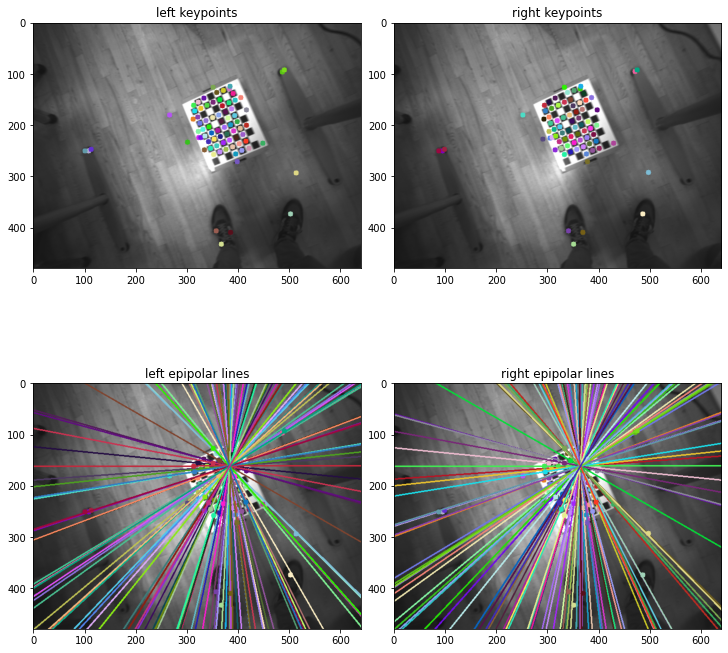

In [37]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
epilines_left, keypoints_left = drawlines(img_left, img_right, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
epilines_right, keypoints_right = drawlines(img_right, img_left, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(keypoints_right)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(keypoints_left)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(epilines_left)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(epilines_right)
axs[1, 1].set_title('right epipolar lines')
plt.show()

## STEP 5: Find the Projection matrices
* Can be down boring way using the following calibration function
* cv2.stereoCalibrate()
* cv2.stereoRectify()

In [38]:
E = K_left.T@F@K_right
R_right, _, t_right = cv2.decomposeEssentialMat(E)
R_left = np.identity(3)
t_left = np.zeros(shape=(3,1))
#cv2.stereoRectify(K_left, dist_left, K_right, dist_right, img.shape[:2], R_left, t )
P_left = np.hstack((K_left@R_left, K_left@t_left))
P_right = np.hstack((K_right@R_right, K_right@t_right))


## STEP 6: Rectifie the images

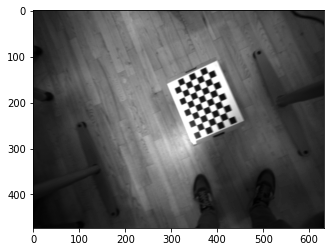

In [39]:
# Load undistorted images (without beeing messed up for some unknown reason)
leftMapX, leftMapY = cv2.initUndistortRectifyMap(K_left,dist_left,R_left,P_left,(w,h),cv2.CV_32FC1)
left_rectified = cv2.remap(img_left,leftMapX,leftMapY,cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

rightMapX, rightMapY = cv2.initUndistortRectifyMap(K_right,dist_right,R_right,P_right,(w,h),cv2.CV_32FC1)
right_rectified = cv2.remap(img_right,rightMapX,rightMapY,cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

#TODO: crop the black parts of the image
plt.imshow(left_rectified, cmap="gray")

## STEP 7: Visualize the changes
* following exercise 2 - epipolar lines (deleted all the comments)

<Figure size 720x720 with 0 Axes>

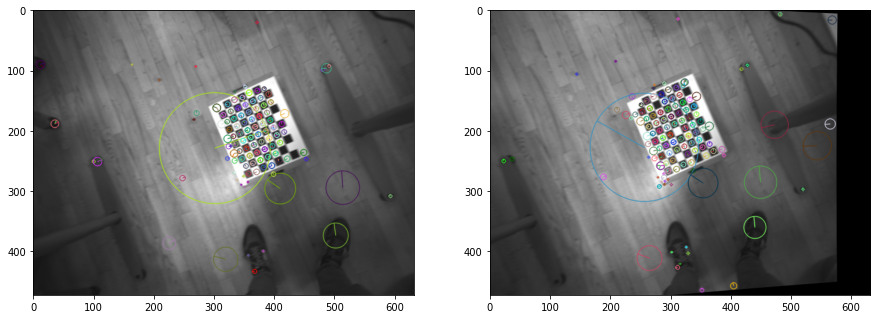

<Figure size 720x720 with 0 Axes>

In [40]:
img1 =  left_rectified.copy()
img2 =  right_rectified.copy()


# Create a sift detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img_left = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_right = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(kp_img_left)
ax2.imshow(kp_img_right)
plt.figure(figsize = (10,10))

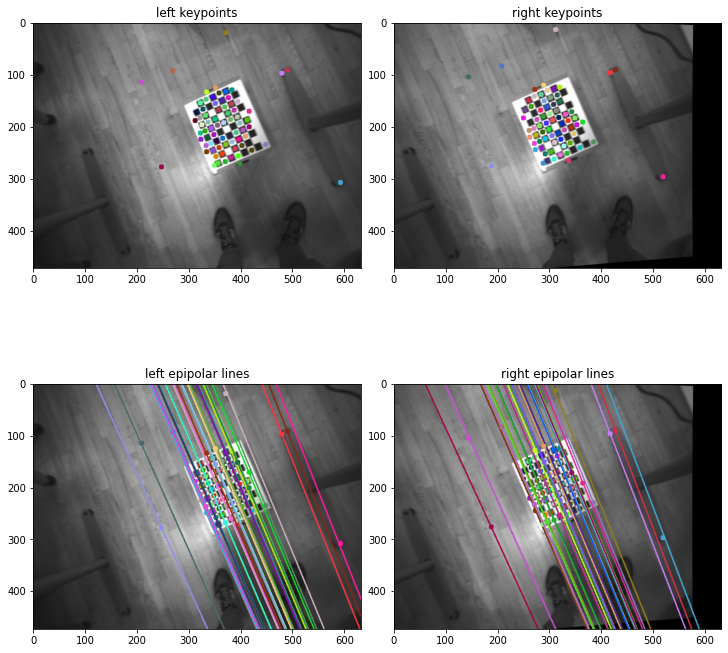

In [41]:

"""
Mathcers
"""
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)

#flann = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
#matches = flann.match(des1, des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)


# Number of points selected
nb_matches = 200

good = []
pts1 = []
pts2 = []

# Using 200 best matches
for m in matches[:nb_matches]:
    good.append(m)
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Find the fundamental matrix: SVD + RANSAC
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()